# Introduction

Trying to predict the rating of a laptop using ML. <br>
The ML algorythm used is going to be lineal regression.

In [29]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [30]:
path = "../data/Amazon Laptop Data.csv"
df = pd.read_csv(path, encoding="utf-8", encoding_errors= "replace")
df.head()

,Product Name,Original Price (in Rs.),Discount Percentage,Final Price (in Rs.),Ratings,Total Ratings count
0,Dell 14 Laptop,"57,778",39%,"34,990",3.8,499
1,Dell 15 Laptop,"51,254",22%,"39,990",4.3,19
2,Dell Inspiron 3530 Laptop,"87,262",30%,"60,990",3.7,68
3,HP Laptop 15s,"56,261",33%,"37,699",4,755
4,"Lenovo V15 Intel Celeron N4500 15.6"" (39.62 cm...","42,032",52%,"19,990",3.8,255


# Functions

I am using General Expresions to extract the number out of the string in Original Price and Final Price

In [31]:
import re

Function used to strip numeric values from a string of text

## Extracion of the numeric values in the string

In [32]:
def convert_to_numeric(x):
    values = re.findall(r'\d+', x) #Extracts the numeric values in the string and creates a list with them
    number = ""
    for i in values: #Iterate through the list
        number = number + i #Create a new string where it is only the numeric values
    return int(number)

## Brand extraction from "Product Name"

In [33]:
def brand_extraction(x):
    return x.split(" ")[0]

## Rating

If a laptop doesn't have reviews its value will be changed to 0. <br>
After that its value will be extracted from the string.

In [34]:
def no_rating_convertion(x):
    if x == "No Ratings":
        x = 0
        return x
    if "," in x:
        values = int("".join(x.split(","))) # Creates a number based on the list created by splitting at "," and joining the components of the list afterwards
        return values
    else:
        return float(x)

## Percentage Extraction

In [35]:
def percentage(x):
    quantity = str(x).split("%")[0]
    return float(quantity)

## Bins by quartiles

In [36]:
def bins(x):
    df[x] = pd.qcut(df[x], q=5, labels=[0.2, 0.4, 0.6, 0.8, 1])

# Data Cleaning

We first have to extract the numeric values from Original Price and Final Price

In [38]:
df.isna().sum()

Product Name               0
Original Price (in Rs.)    0
Discount Percentage        7
Final Price (in Rs.)       0
Ratings                    0
Total Ratings count        0
dtype: int64

In [39]:
df["Discount Percentage"] = df["Discount Percentage"].fillna(0) # Nans are replaced with 0s because if there is a missing value in the discount percentage, it probably means there was no discount
df["Discount"] = df["Discount Percentage"].apply(lambda x: percentage(x))

In [40]:
df["Final Price"] = df["Final Price (in Rs.)"].apply(lambda x: convert_to_numeric(x))
df["Original Price"] = df["Original Price (in Rs.)"].apply(lambda x: convert_to_numeric(x))
df = df.drop(["Original Price (in Rs.)", "Final Price (in Rs.)"], axis=1) #The original columns are no longer useful

In [41]:
df["Ratings"] = df["Ratings"].apply(lambda x: no_rating_convertion(x))

In [42]:
df["Total Ratings count"] = df["Total Ratings count"].apply(lambda x: no_rating_convertion(x))
df["Total Ratings count"].describe()

count     7462.000000
mean        48.255696
std        380.749860
min          0.000000
25%          0.000000
50%          1.000000
75%         19.000000
max      29051.000000
Name: Total Ratings count, dtype: float64

<Axes: >

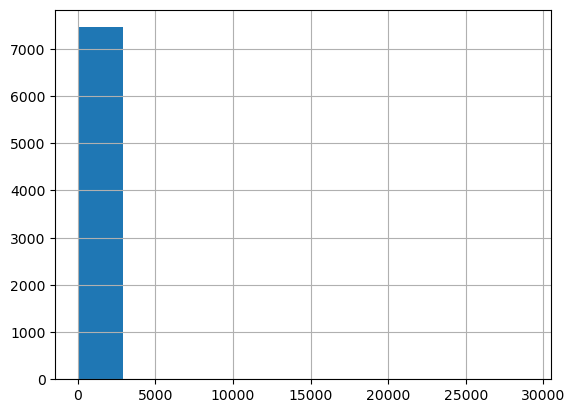

In [43]:
df["Total Ratings count"].hist()

The result is highly skewed, the lower values have a much higher apperance rate than the larger values. <br>
To fix this, we will use a boxcox transformation to try and have a moore normalized set. 

## Boxocox transformation

In [44]:
from scipy.stats import boxcox

<Axes: >

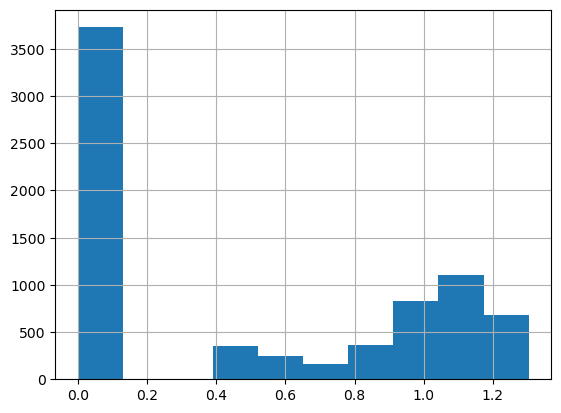

In [45]:
df["Total Ratings count"] = df["Total Ratings count"] - df["Total Ratings count"].min() + 1 #Making sure all values are positive
df["Ratings_count"], lambda_ = boxcox(df["Total Ratings count"]) #The boxcox operator unpacks two values, the transformation and the best lambda value for the transformation
df["Ratings_count"] = np.log1p(df["Ratings_count"]) #We transform the data again, but no with the log1p operator in numpy
df["Ratings_count"].hist()

In [46]:
df["Ratings_count"].describe()

count    7462.000000
mean        0.488393
std         0.514712
min         0.000000
25%         0.000000
50%         0.477847
75%         1.038079
max         1.303301
Name: Ratings_count, dtype: float64

We can clearly see that the problem with the distribution has been fixed.

## Discretizing variables

In [47]:
bins("Original Price")
bins("Final Price")
bins("Discount")

## Target encoding

Target encoding is used to encode categorical features in based on the variables relationship with the target feature

In [48]:
from sklearn.preprocessing import TargetEncoder

In [49]:
enc = TargetEncoder(smooth="auto")
df["Brand"] = df["Product Name"].apply(lambda x: brand_extraction(x)) #Extracts the brands out of the text
X = df[["Brand"]]
Y = df["Ratings"] #It is essential to this type of encoding to give the target feature
df["Brand"] = enc.fit_transform(X,Y) #Does the target encoding

In [50]:
df = df.drop(["Product Name", "Discount Percentage", "Total Ratings count"], axis=1) #This variables are no longer useful for us

# Linear Regression

## Train Test Splits

In [51]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, cross_val_score

In [52]:
x = df.drop(["Ratings"], axis=1)
y = df["Ratings"]

In [53]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size= 0.8, random_state= 37) #We create our splits for the training of our model
reg = LinearRegression()
reg.fit(x_train, y_train)

LinearRegression()

## Scoring the model

There are various ways to score a lineal regression:

- For the frist 3 scores, the lower the score the better, it is a distance based scoring method<br>

- For r2, the closer the value is to 1 the better it represents the general behaviour of the data<br>

- For cross validation, the less variance there is between the values, the better the model is<br>


In [54]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

predict = reg.predict(x_test)

mae = mean_absolute_error(y_test, predict)
mse = mean_squared_error(y_test, predict)
rmse = mean_squared_error(y_test, predict, squared=False)
r2 = r2_score(y_test, predict)
cv_scores = cross_val_score(reg, x, y, cv=5, scoring='r2')

print(f"Mean Absolute Error: {mae}")
print(f"Mean Squared Error: {mse}")
print(f"Root Mean Squared Error: {rmse}")
print(f"R-squared (Coefficient of Determination): {r2}")
print(f"Result of cross_validation: {cv_scores}")

Mean Absolute Error: 0.40051048253792654
Mean Squared Error: 0.458491952497687
Root Mean Squared Error: 0.6771203382691197
R-squared (Coefficient of Determination): 0.8785780753009682
Result of cross_validation: [0.69815823 0.73922576 0.9088537  0.89379848 0.92269404]


c:\Users\Roi_f\anaconda3\envs\personal\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
